In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from src.io.cache_io import temp_dir
from src.io.data_io import DataFile
from src.loggers import set_console_handler_level
from src.managers.data_managers import CrisprScreenDataManager
from src.models.speclet_eight import SpecletEight
from src.plot.color_pal import SeabornColor
from src.plot.plotnine_helpers import set_gg_theme

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.INFO)
set_gg_theme()
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1026
np.random.seed(RANDOM_SEED)

In [49]:
from src.models.speclet_eight import SpecletEight

[10/14/21 16:23:53] INFO     Creating a new SpecletEight object.          ]8;id=776051;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:72

                    INFO     Adding new transformation.                  ]8;id=788348;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:171

                    INFO     Calling `model_specification()` method.     ]8;id=21043;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:205

                    INFO     Creating SpecletEight model.                ]8;id=949693;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:103

                    INFO     Getting data - reading from file.           ]8;id=311763;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:126

                    WARNING  Dropping 0 sgRNA that map to multiple genes.     ]8;id=529369;file:///Users/admin/Lab_Projects/speclet/src/data_processing/achilles.py\achilles.py]8;;\:616

                    INFO     Adding 'rna_expr_gene_lineage' column. ]8;id=348945;file:///Users/admin/Lab_Projects/speclet/src/modeling/feature_engineering.py\feature_engineering.py]8;;\:73

[10/14/21 16:23:54] INFO     Number of data points: 960                  ]8;id=80131;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:107

                    INFO     Number of sgRNA: 160                        ]8;id=186542;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:109

                    INFO     Number of genes: 101                        ]8;id=203213;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:110

                    INFO     Number of cell lines: 6                     ]8;id=718332;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:111

                    INFO     Number of lineages: 1                       ]8;id=115278;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:112

                    INFO     Creating shared variables.                  ]8;id=177315;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:115

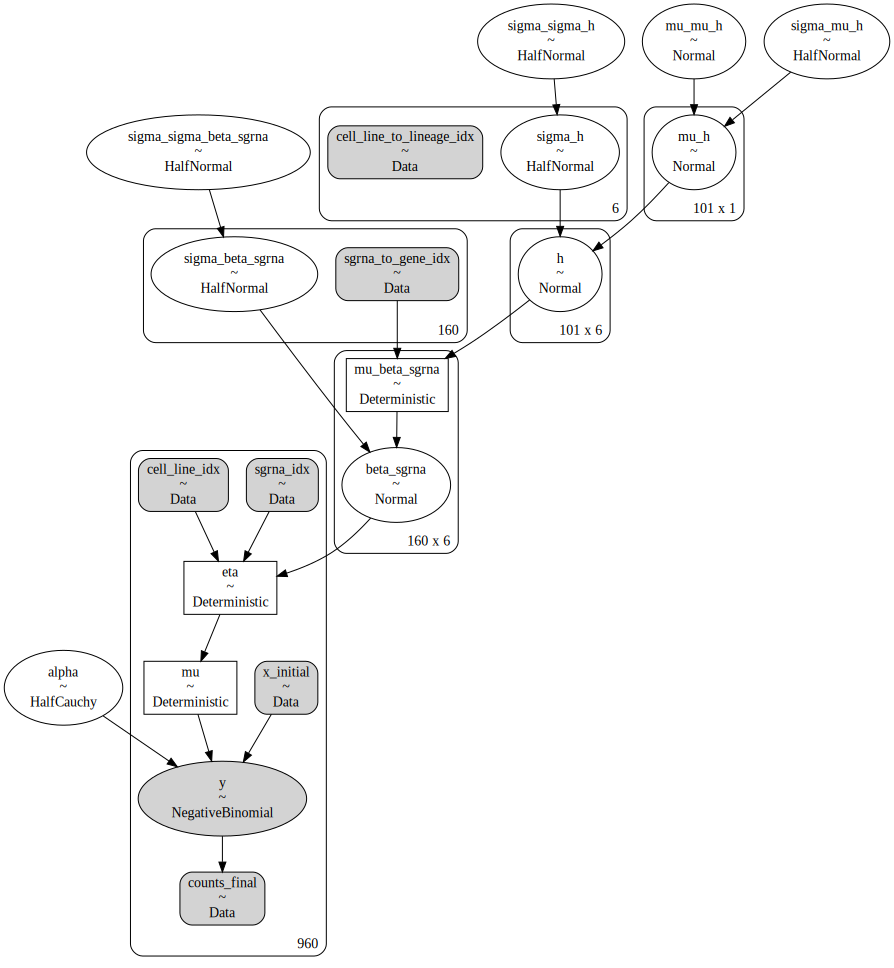

In [50]:
dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_SUBSAMPLE)
sp8 = SpecletEight("design-model", data_manager=dm, root_cache_dir=temp_dir())
sp8.build_model()
pm.model_to_graphviz(sp8.model)

In [52]:
sp8_mcmc_post = sp8.mcmc_sample_model(
    draws=1000,
    tune=500,
    chains=2,
    cores=2,
    target_accept=0.85,
    prior_pred_samples=-1,
    random_seed=RANDOM_SEED,
    ignore_cache=True,
    sample_kwargs={"init": "advi", "n_init": 20000},
)

[10/14/21 16:35:48] INFO     Beginning MCMC sampling.                    ]8;id=894436;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:304

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 7,200.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_sgrna, sigma_beta_sgrna, sigma_sigma_beta_sgrna, h, sigma_h, sigma_sigma_h, mu_h, sigma_mu_h, mu_mu_h]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1680 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


[10/14/21 17:05:54] INFO     Not sampling from prior predictive.     ]8;id=235129;file:///Users/admin/Lab_Projects/speclet/src/modeling/pymc3_sampling_api.py\pymc3_sampling_api.py]8;;\:92

                    INFO     Finished MCMC sampling - caching results.   ]8;id=44182;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:315

                    INFO     Caching InferenceData to '/Users/admin/Lab_ ]8;id=337797;file:///Users/admin/Lab_Projects/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:94
                             Projects/speclet/temp/design-model/mcmc/inf                     
                             erence-data.nc'.

In [53]:
sp8_vars: list[str] = [
    "mu_mu_h",
    "sigma_mu_h",
    "mu_h",
    "sigma_sigma_h",
    "sigma_h",
    "h",
    "mu_beta_sgrna",
    "sigma_sigma_beta_sgrna",
    "sigma_beta_sgrna",
    "beta_sgrna",
    "alpha",
]

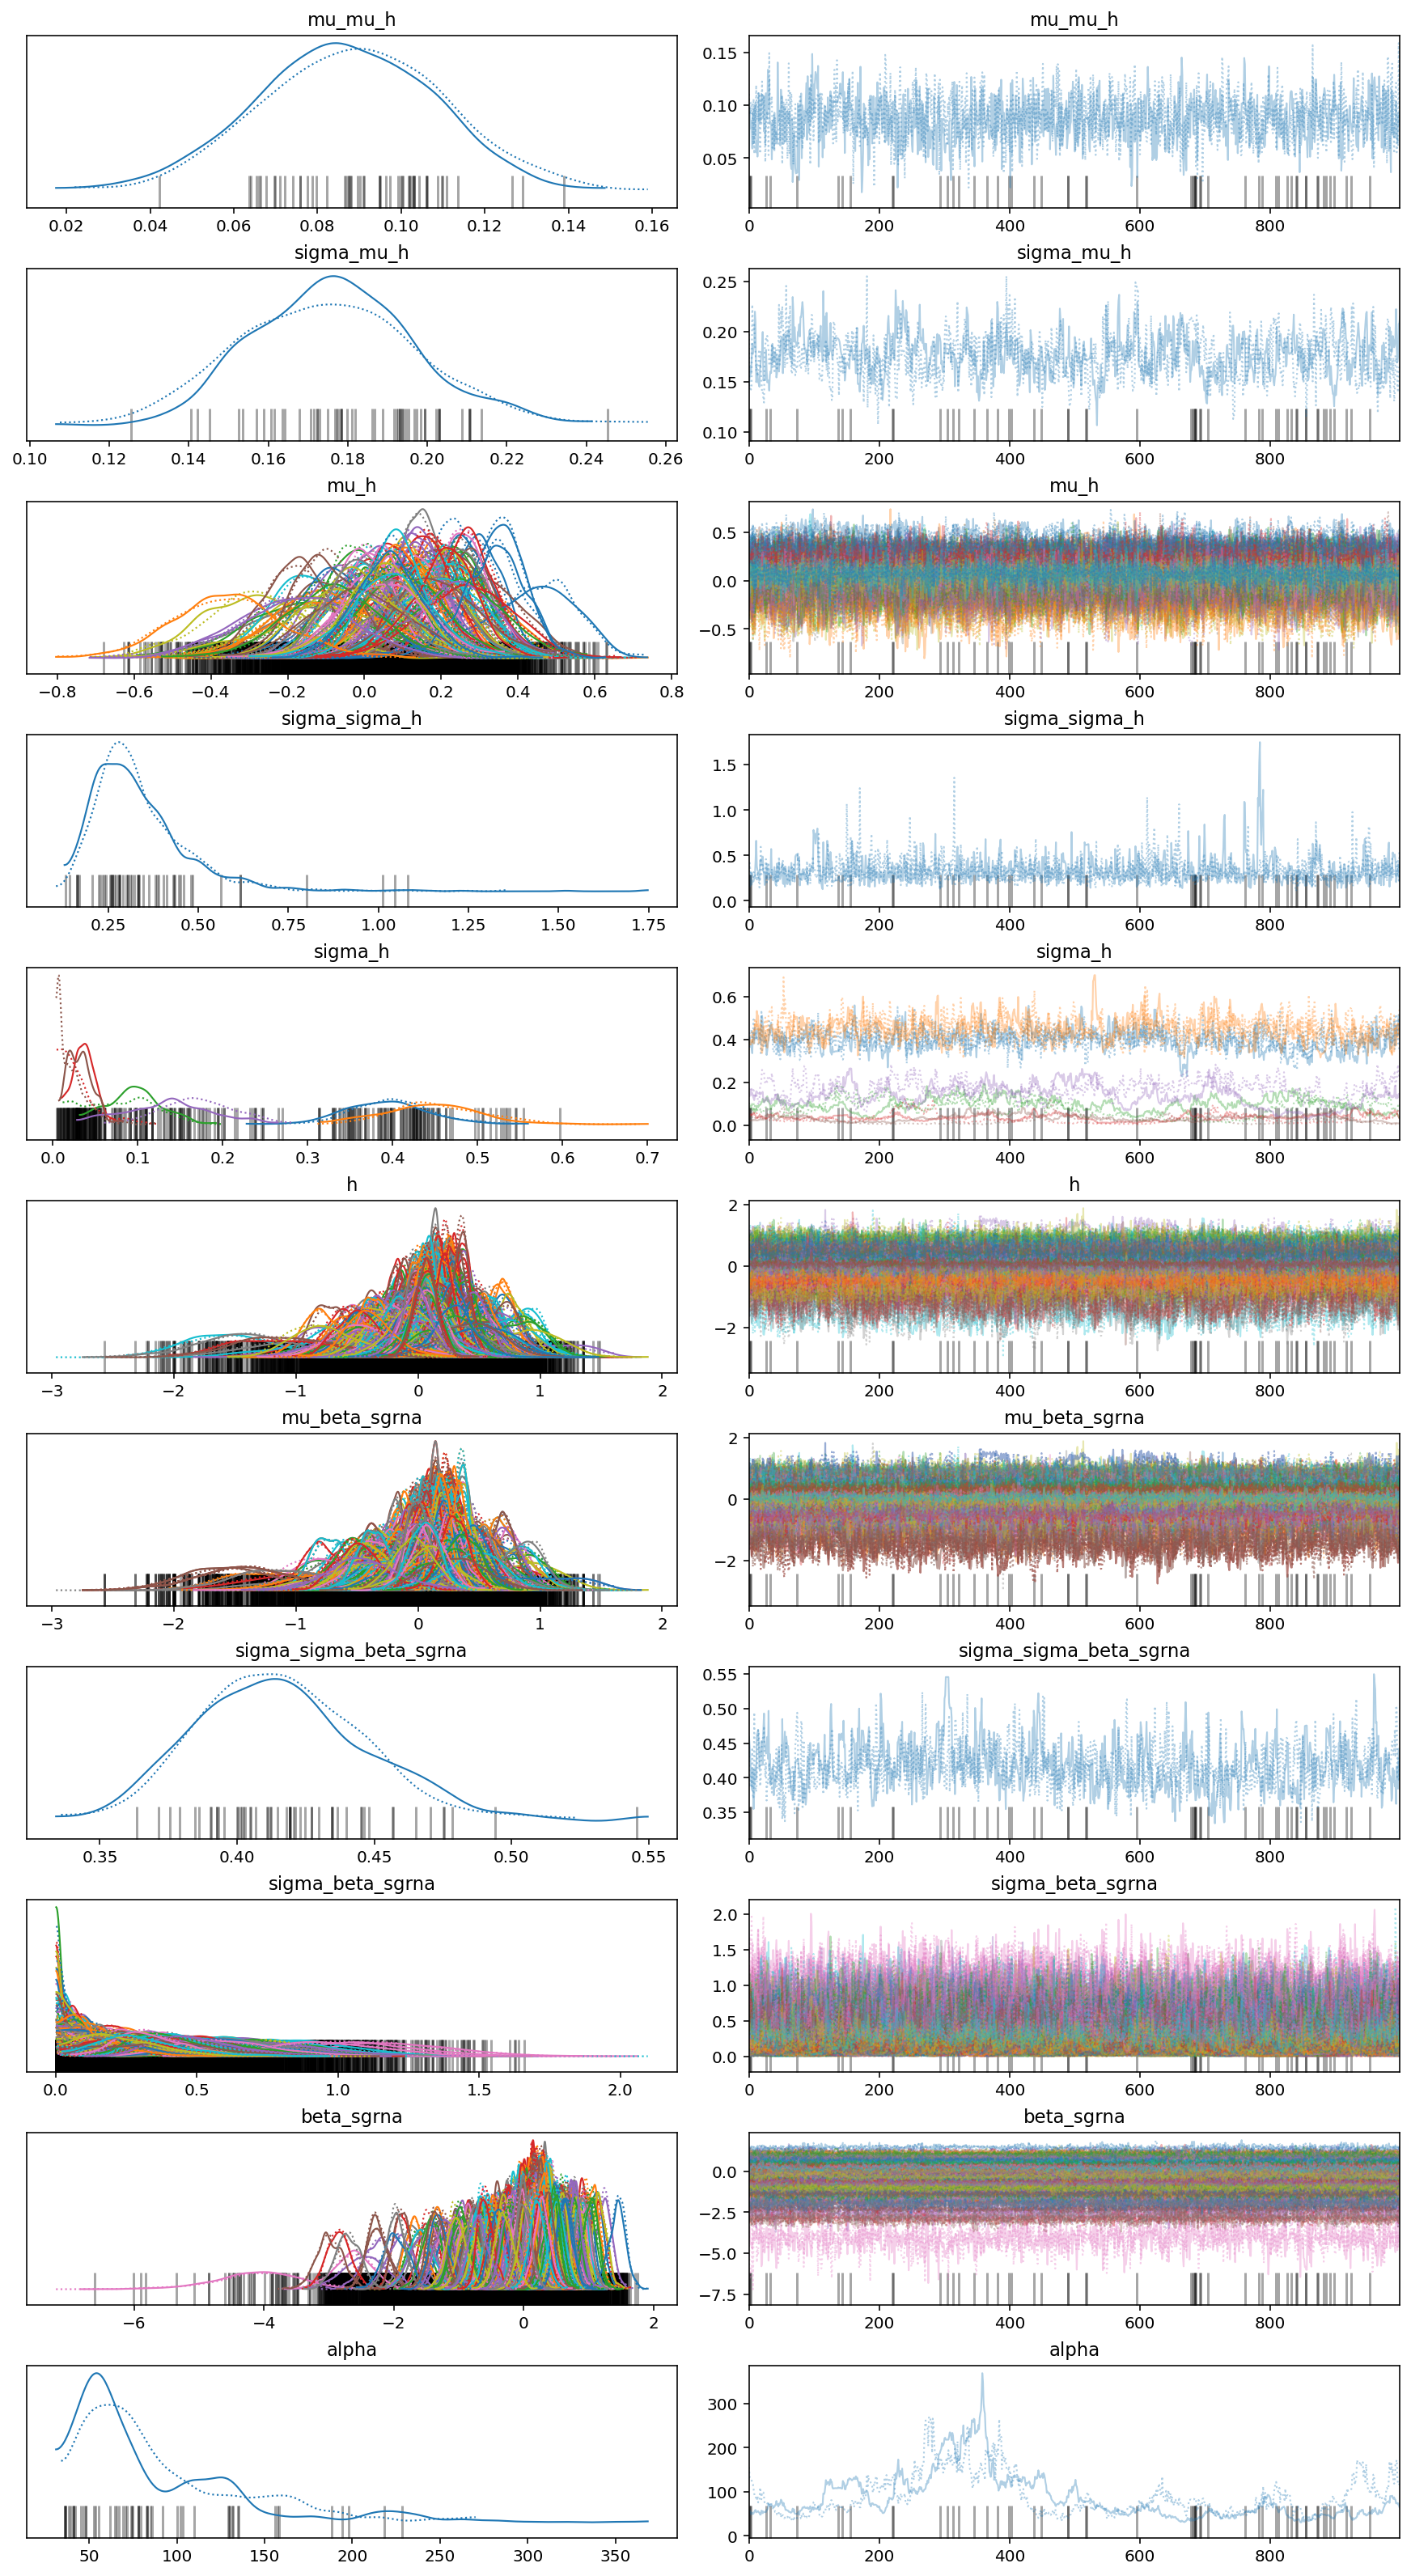

In [54]:
az.plot_trace(sp8_mcmc_post, var_names=sp8_vars);

In [55]:
az.summary(sp8_mcmc_post, var_names=sp8_vars).query("r_hat > 1.1")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_h[2],0.088,0.037,0.016,0.148,0.011,0.008,13.0,23.0,1.15
sigma_h[4],0.154,0.050,0.059,0.249,0.016,0.011,10.0,21.0,1.14
alpha,88.531,49.502,30.711,183.072,16.273,11.890,7.0,44.0,1.24


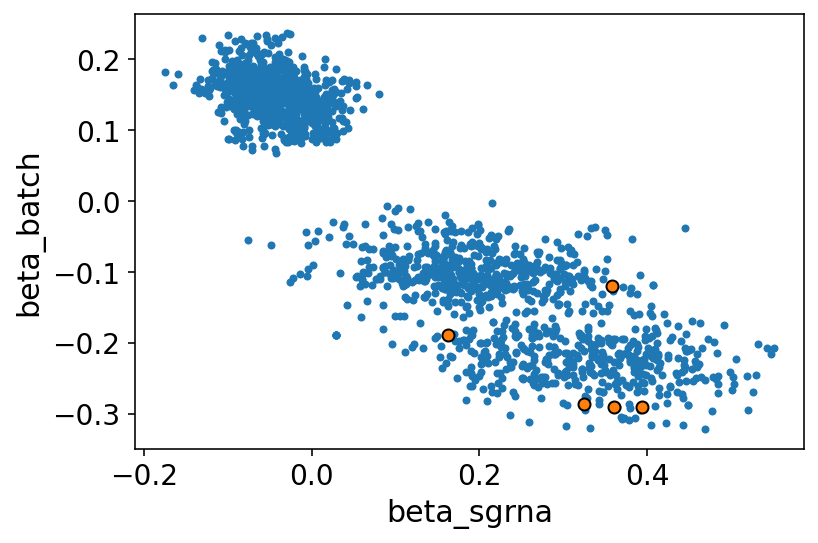

In [9]:
# az.plot_pair(
#     sp8_mcmc_post,
#     var_names=["beta_sgrna", "beta_batch"],
#     coords={"sgrna": "AGCTGAGCGCAGGGACCGGG", "batch": "2", "cell_line": "ACH-000007"},
#     divergences=True,
# );

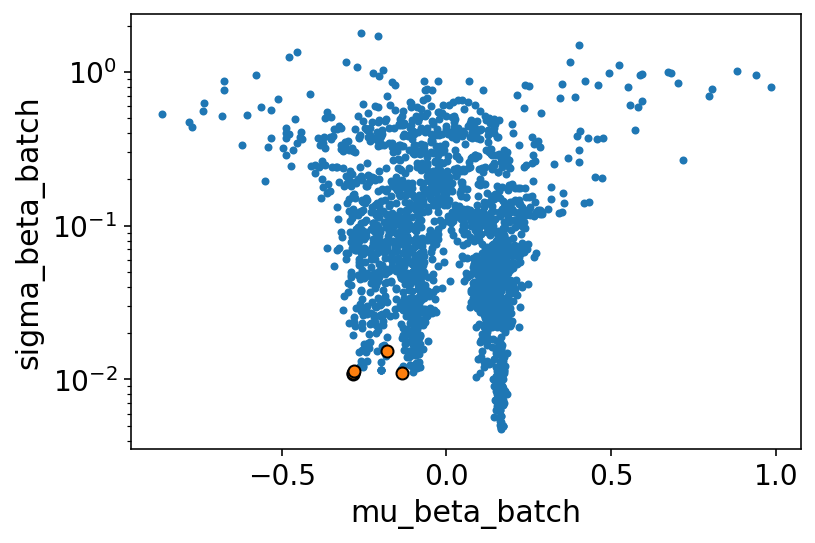

In [10]:
ax = az.plot_pair(
    sp8_mcmc_post,
    var_names=["mu_beta_batch", "sigma_beta_batch"],
    divergences=True,
)
ax.set_yscale("log");

---

notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-10-14

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: speclet-eight

plotnine  : 0.8.0
numpy     : 1.21.2
pymc3     : 3.11.2
arviz     : 0.11.2
matplotlib: 3.4.3
pandas    : 1.3.2
logging   : 0.5.1.2
sys       : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
seaborn   : 0.11.2

